# Load forecasting benchmark

Example created by Wilson Rocha Lacerda Junior

## Note

The following example is **not** intended to say that one library is better than another. The main focus of these examples is to show that SysIdentPy can be a good alternative for people looking to model time series.

We will compare the results obtained against **neural prophet** library.

For the sake of brevity, from **SysIdentPy** only the **MetaMSS**, **AOLS** and **FROLS** (with polynomial base function) methods will be used. See the SysIdentPy documentation to learn other ways of modeling with the library.


We will compare a 1-step ahead forecaster on electricity consumption of a building. The config of the neuralprophet model was taken from the neuralprophet documentation (https://neuralprophet.com/html/example_links/energy_data_example.html)

The training will occur on 80% of the data, reserving the last 20% for the validation.

Note: the data used in this example can be found in neuralprophet github.

# Benchmark results:

| No. | Package | Mean Squared Error |
| --- | ------- | ----------------- |
| 1 | SysIdentPy (FROLS) | 4183 |
| 2 | SysIdentPy (MetaMSS) | 5264 |
| 3 | SysIdentPy (AOLS) | 5264 |
| 4 | NeuralProphet | 11471 |

In [4]:
from warnings import simplefilter
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

from sysidentpy.model_structure_selection import FROLS
from sysidentpy.model_structure_selection import AOLS
from sysidentpy.model_structure_selection import MetaMSS
from sysidentpy.basis_function import Polynomial
from sysidentpy.utils.plotting import plot_results
from sysidentpy.neural_network import NARXNN
from sysidentpy.metrics import mean_squared_error

from sktime.datasets import load_airline
from neuralprophet import NeuralProphet
from neuralprophet import set_random_seed 


simplefilter("ignore", FutureWarning)
np.seterr(all="ignore")

%matplotlib inline

loss = mean_squared_error

data_location = r"examples\datasets"

## FROLS

WARNING - (py.warnings._showwarnmsg) - /Users/arturo.melendez/Documents/Quetzal/sysidentpy/sysidentpy/model_structure_selection/forward_regression_orthogonal_least_squares.py:541: UserWarning: n_info_values is greater than the maximum number of all regressors space considering the chosen y_lag, u_lag, and non_degree. We set as 5
  self.info_values = self.information_criterion(reg_matrix, y)



06-09 09:41:09 - WARNING - /Users/arturo.melendez/Documents/Quetzal/sysidentpy/sysidentpy/model_structure_selection/forward_regression_orthogonal_least_squares.py:541: UserWarning: n_info_values is greater than the maximum number of all regressors space considering the chosen y_lag, u_lag, and non_degree. We set as 5
  self.info_values = self.information_criterion(reg_matrix, y)

4183.359498155754


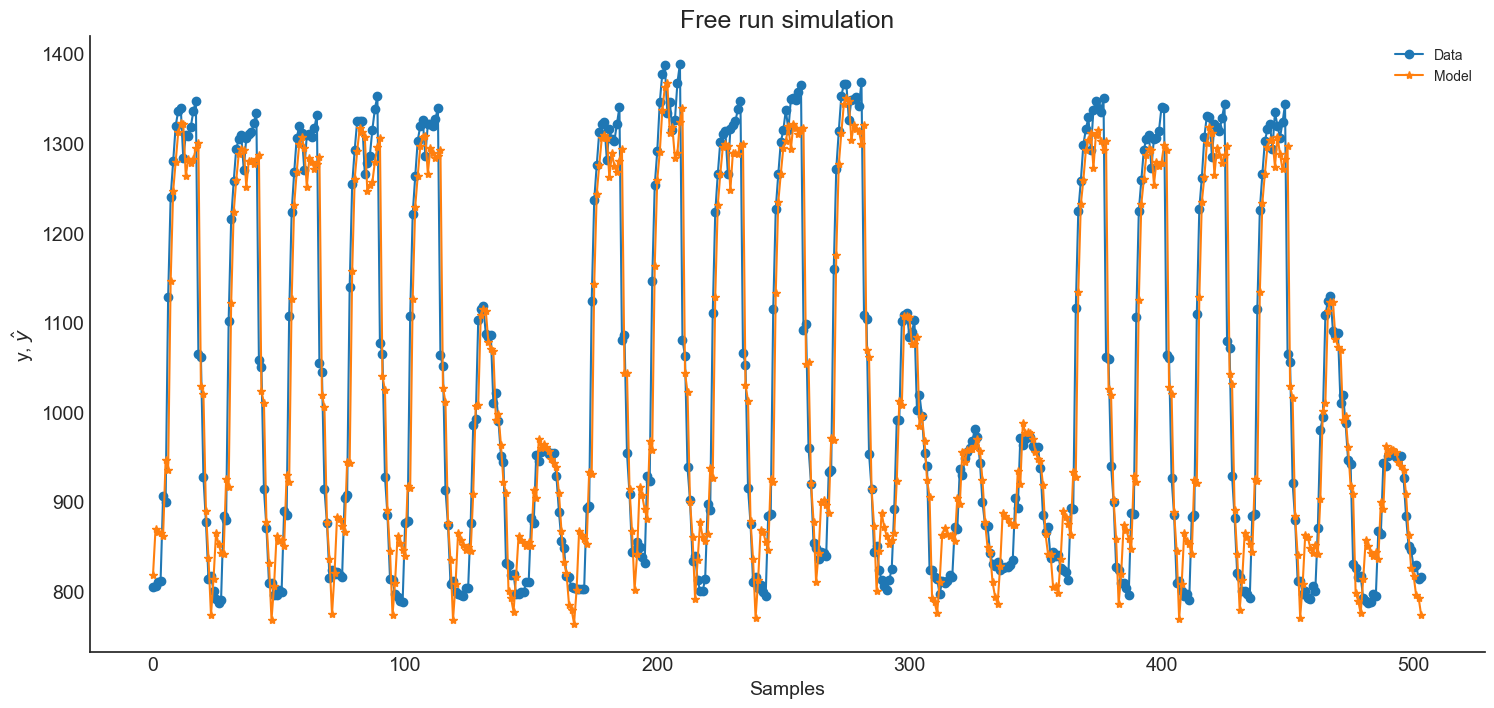

In [8]:
files = ['\SanFrancisco_Hospital.csv']
raw = pd.read_csv('datasets/SanFrancisco_Hospital.csv')
df = pd.DataFrame()
df['ds'] = pd.date_range('1/1/2015 1:00:00', freq=str(60) + 'Min',
                               periods=(8760)) 
df['y'] = raw.iloc[:,0].values

df_train, df_val = df.iloc[:7008, :], df.iloc[7008:, :]

y = df['y'].values.reshape(-1, 1)
y_train = df_train['y'].values.reshape(-1, 1)
y_test = df_val['y'].values.reshape(-1, 1)

x_train = df_train['ds'].dt.hour.values.reshape(-1, 1)
x_test = df_val['ds'].dt.hour.values.reshape(-1, 1)

basis_function = Polynomial(degree=1)
sysidentpy = FROLS(
    order_selection=True,
    info_criteria='bic',
    estimator="least_squares",
    basis_function=basis_function,
)
sysidentpy.fit(X=x_train, y=y_train)
x_test = np.concatenate([x_train[-sysidentpy.max_lag:], x_test])
y_test = np.concatenate([y_train[-sysidentpy.max_lag:], y_test])

yhat = sysidentpy.predict(X=x_test, y=y_test, steps_ahead=1)
sysidentpy_loss = loss(pd.Series(y_test.flatten()[sysidentpy.max_lag:]), pd.Series(yhat.flatten()[sysidentpy.max_lag:]))
print(sysidentpy_loss)


plot_results(y=y_test[-504:], yhat=yhat[-504:], n=504, figsize=(18, 8))

In [12]:
x_test

array([[23],
       [ 0],
       [ 1],
       ...,
       [22],
       [23],
       [ 0]], dtype=int32)

## MetaMSS

In [ ]:
files = ['\SanFrancisco_Hospital.csv']
raw = pd.read_csv(data_location + files[0])
df=pd.DataFrame()
df['ds'] = pd.date_range('1/1/2015 1:00:00', freq=str(60) + 'Min',
                               periods=(8760)) 
df['y'] = raw.iloc[:,0].values

df_train, df_val = df.iloc[:7008, :], df.iloc[7008:, :]

y = df['y'].values.reshape(-1, 1)
y_train = df_train['y'].values.reshape(-1, 1)
y_test = df_val['y'].values.reshape(-1, 1)

x_train = df_train['ds'].dt.hour.values.reshape(-1, 1)
x_test = df_val['ds'].dt.hour.values.reshape(-1, 1)
basis_function = Polynomial(degree=1)
sysidentpy_metamss = MetaMSS(
    xlag=2,
    ylag=2,
    basis_function=basis_function,
    estimator="least_squares",
    steps_ahead=1,
    n_agents=15,
    random_state=42
    )
sysidentpy_metamss.fit(X=x_train, X_test=x_test, y=y_train, y_test=y_test)
x_test = np.concatenate([x_train[-sysidentpy_metamss.max_lag:], x_test])
y_test = np.concatenate([y_train[-sysidentpy_metamss.max_lag:], y_test])

yhat = sysidentpy_metamss.predict(X=x_test, y=y_test, steps_ahead=1)
metamss_loss = loss(
    pd.Series(y_test.flatten()[sysidentpy_metamss.max_lag:]),
    pd.Series(yhat.flatten()[sysidentpy_metamss.max_lag:]))
print(metamss_loss)


plot_results(y=y_test[:700], yhat=yhat[:700], n=504, figsize=(18, 8))

## AOLS

In [ ]:
set_random_seed(42)
files = ['\SanFrancisco_Hospital.csv']
raw = pd.read_csv(data_location + files[0])
df=pd.DataFrame()
df['ds'] = pd.date_range('1/1/2015 1:00:00', freq=str(60) + 'Min',
                               periods=(8760)) 
df['y'] = raw.iloc[:,0].values

df_train, df_val = df.iloc[:7008, :], df.iloc[7008:, :]

y = df['y'].values.reshape(-1, 1)
y_train = df_train['y'].values.reshape(-1, 1)
y_test = df_val['y'].values.reshape(-1, 1)

x_train = df_train['ds'].dt.hour.values.reshape(-1, 1)
x_test = df_val['ds'].dt.hour.values.reshape(-1, 1)
basis_function = Polynomial(degree=1)
sysidentpy_AOLS = AOLS(
    xlag=2,
    ylag=2,
    basis_function=basis_function
)
sysidentpy_AOLS.fit(X=x_train, y=y_train)
x_test = np.concatenate([x_train[-sysidentpy_AOLS.max_lag:], x_test])
y_test = np.concatenate([y_train[-sysidentpy_AOLS.max_lag:], y_test])

yhat = sysidentpy_AOLS.predict(X=x_test, y=y_test, steps_ahead=1)
aols_loss = loss(pd.Series(y_test.flatten()[sysidentpy_AOLS.max_lag:]), pd.Series(yhat.flatten()[sysidentpy_AOLS.max_lag:]))
print(aols_loss)


plot_results(y=y_test[-504:], yhat=yhat[-504:], n=504, figsize=(18, 8))

## Neural Prophet

In [ ]:
set_random_seed(42)

# set_log_level("ERROR")
files = ['\SanFrancisco_Hospital.csv']
raw = pd.read_csv(data_location + files[0])
df = pd.DataFrame()
df['ds'] = pd.date_range('1/1/2015 1:00:00', freq=str(60) + 'Min',
                               periods=(8760)) 
df['y'] = raw.iloc[:,0].values

m = NeuralProphet(
    n_lags=24,
    ar_sparsity=0.5,
    num_hidden_layers = 2,
    d_hidden=20,
    learning_rate=0.001
)
metrics = m.fit(df, freq='H', valid_p = 0.2)

df_train, df_val = m.split_df(df,valid_p=0.2)
m.test(df_val)

future = m.make_future_dataframe(df_val, n_historic_predictions=True)
forecast = m.predict(future)
# fig = m.plot(forecast)
print(loss(forecast['y'][24:-1], forecast['yhat1'][24:-1]))

neuralprophet_loss = loss(forecast['y'][24:-1], forecast['yhat1'][24:-1])

In [ ]:
plt.figure(figsize=(18, 8))
plt.plot(forecast['y'][-504:], 'ro-')
plt.plot(forecast['yhat1'][-504:], 'k*-')

In [ ]:
results = {'SysIdentPy - FROLS': sysidentpy_loss, 'SysIdentPy (AOLS)': aols_loss,
 'SysIdentPy (MetaMSS)': metamss_loss, 'NeuralProphet': neuralprophet_loss}

sorted(results.items(), key=lambda result: result[1])